### Project Overview: Deep Q-Learning for Multi-Agent Grid Delivery

This project implements a Deep Q-Learning (DQL) algorithm in a multi-agent grid environment where agents must learn to transport items from a source point (A) to a destination point (B) efficiently and safely.

### Objective

The system trains agents to:

Navigate a 5x5 grid environment.
Pick up items from point A and deliver them to point B.
Avoid collisions with other agents.
Minimize delivery steps and complete tasks successfully.

### Core Components

1. DQL Class
Defines the deep Q-learning agent with:
Neural networks (main_nn, target_nn)
Experience replay
Epsilon-greedy strategy for exploration
Bellman update training logic

2. agent Class
Represents an individual delivery agent with attributes for:
Position (x, y)
Item possession (has_item)

3. grid_state Class
Defines the environment with:
Randomized A/B point locations
Multiple agents moving simultaneously
State representation, reward calculation, and collision logic

4. Training and Evaluation
Functions train_process and test handle:
Training over episodes and steps
Experience sampling and model updates
Evaluation of success rate and collisions across scenarios

5. Options

    -Central clock

    -State of neighbouring cells checked for agents of opposite type



### Class DQL - Deep Q-Learning Agent

This class implements a Deep Q-Learning (DQL) agent. It handles model setup, training logic, epsilon-greedy strategy, and Q-value calculation.

#### Attributes:

- statespace_size: Size of the input state vector. Set to 19.

- replay_buffer: List storing past experiences as tuples (state, action, reward, next_state).

- lr: Learning rate for neural network optimization (1e-3).

- gamma: Discount factor for future rewards (0.95).

- replay_buffer_size: Maximum number of experiences stored in the buffer (50,000).

- batch_size: Number of samples used per training update (64).

- target_update_freq: Frequency (in episodes) for syncing target network with main network (50).

- epsilon, epsilon_decay, min_epsilon: Parameters controlling exploration in epsilon-greedy strategy.

- main_nn, target_nn: The neural networks for learning and stable Q-value estimation.

- loss_fn, optimizer: Loss function and optimizer for model training.

#### Key Methods:

- prepare_torch(): Builds the neural network models with 3 fully connected layers, ReLU activations, and output layer size 4 (number of actions).

- get_qvals(state): Returns the Q-values from the main network for a given input state.

- update_target(): Copies weights from main_nn to target_nn for stable target prediction.

- update_replay_buffer(s, a, r, s_next): Appends a new experience to the replay buffer, dropping oldest if full.

- get_maxQ(s_next): Computes the maximum predicted Q-value for next state using target_nn.

- update_epsilon(): Applies decay to epsilon after each episode.

- selection_action(state): Chooses an action in given valid_actions using epsilon-greedy policy (random with probability epsilon, else argmax Q).

In [26]:
import numpy as np
import random
import copy
import time
import torch
from itertools import permutations
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib.widgets import Button
from IPython.display import HTML
loss_list = []
avg_loss = []


reward_list = []
avg_reward = []

pos_reward_per = []

class DQL:
    
    def __init__(self, statespace_size, lr, gamma, replay_buffer_size, batch_size, target_update_freq, epsilon, epsilon_decay, min_epsilon):
        self.statespace_size = statespace_size
        self.replay_buffer = []
        self.lr = lr
        self.gamma = gamma   # discount factor for future reward
        self.replay_buffer_size = replay_buffer_size
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.epsilon = epsilon    # decay after each episode
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.main_nn = None
        self.target_nn = None
        self.loss_fn = None
        self.optimizer = None
    
    def prepare_torch(self):
        """
        Initialize the neural network
        """
        l1 = self.statespace_size
        l2 = 128
        l3 = 64
        l4 = 4 
        #creat main network
        model = torch.nn.Sequential(
            torch.nn.Linear(l1, l2),
            torch.nn.ReLU(),
            torch.nn.Linear(l2, l3),
            torch.nn.ReLU(),
            torch.nn.Linear(l3,l4))
        
        #creat target network by copy main network and load main network's weight and bias
        model2 = copy.deepcopy(model)
        model2.load_state_dict(model.state_dict())
        
        #creat loss function
        loss_fn = torch.nn.MSELoss()
        
        #create optimizer whicih is used to update the main network
        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
        
        # save main network, targetnetwork, loss function and optimizer
        self.main_nn = model
        self.target_nn = model2
        self.loss_fn = loss_fn
        self.optimizer = optimizer
    
    def get_qvals(self, state):
        """
        return all possible q values for given state

        Args:
            state (list): 19 dimension represent a state

        Returns:
            numpy.ndarray: all possible q values for given state
        """
        # convert a list to np array, then convert it to Tensor, make sure the data inside of it is float
        state1 = torch.from_numpy(np.array(state)).float()
        
        # Input state1 into the main neural network main_nn, and the output is a tensor representing 
        # the Q value prediction of each action in the current state.
        qvals_torch = self.main_nn(state1)
        
        #convert the output tensor to numpy array
        qvals = qvals_torch.data.numpy()
        
        return qvals
    
    def update_target(self):
        """
        
        Copy all the parameters of the main network main_nn to the target network target_nn, 
        so that the weights of the two networks are exactly the same

        """
        self.target_nn.load_state_dict(self.main_nn.state_dict())
        
    def update_replay_buffer(self, state, action, reward, next_state):
        """
        Add a new experience (state transition) to the experience Replay Buffer and keep its size within the upper limit.

        Args:
            state (list): 20 dimension represent a state
            action (int): the action for curretn state
            reward (int): reward after current action
            next_state (list): 20 dimension representative the state after took the given action
        """
        # update replay buffer
        self.replay_buffer.append((state, action, reward, next_state))
        
        # if replay_buffer's size is larger than limit, delete the first one, which is the oldest one
        if len(self.replay_buffer)>self.replay_buffer_size:
            self.replay_buffer.pop(0)
            
    def get_maxQ(self, state):
        """
        Get the max q value in all the possible q values for a given state

        Args:
            state (list): 20 dimension represent a state

        Returns:
            torch.FloatTensor: scalar, a q value

        """
        return torch.max(self.target_nn(torch.from_numpy(np.array(state)).float())).float()    
    
    def update_epsilon(self):
        """
        update epsilon with decay
        """
        # get a new epsilon with decay
        new_epsilon = self.epsilon* self.epsilon_decay
        
        # update epsilon, If it's value is less than the lower limit, 
        # then the epsilon value remains at the lower limit and remains unchanged
        self.epsilon = max(new_epsilon,self.min_epsilon)
        
    def selection_action(self, state, valid_actions):
        """
        For a state, actions are selected using epsilon-greedy based on all the legal actions it can take

        Args:
            state (list): 20 dimension represent a state
            valid_actions (list): number from 0 to 3, represent up, down, left, right

        Returns:
            _type_: _description_
        """
        
        # Generate a random number. If it is less than epsilon, select it randomly; otherwise, adopt the greedy strategy
        if random.uniform(0,1) < self.epsilon:
            if valid_actions is not None:
                
                # randomly chocie an action in all valid actions
                return random.choice(valid_actions)
            
            else:
                return None
        else :
            # Disable gradient calculation (we are only reasoning here, not training) to improve efficiency
            with torch.no_grad():
                
                # get all possible values
                q_values = self.get_qvals(state)  # numpy
                
                #convert it to tensor
                q_values1 = torch.from_numpy(q_values) #tensor
                
                if valid_actions is not None:
                    # mask for invalid_action
                    mask = torch.full_like(q_values1, -1e9)
                    
                    # set 0 for valid action
                    mask[valid_actions] = 0   
                    
                    # for valid action, the value is normal, for invalid action, the value is very low
                    q_values1 = q_values1 + mask 
                    
                # return the index for the largest q value, which stands for specific actions    
                return torch.argmax(q_values1).item()

### Class agent
This class models a single agent in the environment.

#### Attributes:
- x, y: Integer coordinates of the agent in the grid.
- cost:thsi agent's cost
- path:record path
- time no use here
- has_item: Boolean indicating whether the agent is currently carrying an item.

### Class grid_state
This class models the grid environment and manages all agents, goals, and dynamics.

#### Attributes:
- size: Grid size (assumed square, e.g., 5x5).
- num_agents: Number of agents in the environment.
- agent_list: List of agent objects.
- A_location, B_location: Tuple coordinates of source (A) and destination (B).
- total_cost: Sum of steps taken by all agents.
- total_collisions: Count of collisions between agents.
- is_in_same_row, is_in_same_column: Booleans used for spatial logic.

#### Key Methods:
- reset_grid(): Initializes grid with randomly placed A, B and agent positions.
- reset_agents(): Resets all agent states.
- random_position(): Generates random position not equal to A or B.
- get_neighbors(agent): Returns adjacent cells to an agent.
- get_valid_actions(agent): Returns a list of valid actions based on boundaries.
- step(actions): Updates agent positions according to actions, checks collisions and goals.
- check_collision(): Checks for collisions among agents.
- check_goal(): Checks which agents completed delivery from A to B.
- reward_function(): Calculates reward based on goals achieved and collisions.
- get_info(): Returns a flattened vector representing current grid state.

### Key design
- reward design:
    At the beginning, I considered three factors，step cost, goal(delivered) and collision, every the program call this function, it make a step, I want the less step it cost, so the reward is initialized to -1. give goal a weight 10 and collision a weight -30, because I want avoid collision. No collision is important than reach goal.

    After training and testing, I found that the performance of the model was not good. Because only by achieving the goal can there be positive incentives，Such training under the given budget is not efficient。

    Then I add two positive incentives, When agent has item approaching B, I give it a positive reward, or when agent doesn't have item approach A, I give it a positive reward.

    Performance of this model still not good given 500 Collision budget, so I want agents learn a A specific movement pattern.

    Agent has item should approach B, agent without item should approach A, for all agents, I hope their movement pattern is to move horizontally first and then vertically. In this pattern, it can make sure different move in different part of the grid. so I give reward for any move that fit this pattern, otherwise I give it penalty. Also the reward structure reserve the original design, which consider step cost, goal, and collision.
- input layer parameter：
    At the beginning, I designed state with 8 dimension, including agent loccation, A location, B location, has item or not and neighbors. Neighbors was a 8 dimension list, I convert it to binary number then convert it to decimal number. It's not a good design because it is difficult for neural networks to extract the features related to the distance between the agent and AB. Besides, use decimal number represent neighbors' status will make the features about it very unclear. Beside, this number can be much larger than others, which be lead weird loss.
    
    So I added the information of the distances from the horizontal and vertical coordinates of AB，and I use the 8 dimension neighbors list represent neighbors' status, so now the state is 19 dimension.



In [27]:
class agent:
    def __init__(self):
        self.x = None
        self.y = None
        self.has_item = None
        self.cost = 0
        self.time = 1
        self.path = []

class grid_state:
    
    def __init__(self, size, num_agent):
        self.size = size
        self.num_agents = num_agent
        self.A_location = None
        self.B_location = None
        self.agent_list = []
        self.total_cost = 0
        self.total_collisions = 0
        self.is_in_same_row = 0
        self.is_in_same_column = 0
        
    def random_position(self):
        """
        Randomly generate a two-dimensional coordinate within the limited range

        Returns:
            tuple: a two-dimensional coordinate
        """
        return (random.randint(0,self.size-1),random.randint(0,self.size-1))
    
    def reset_agents(self):
        """
        Randomly generate four agents' location in A or B
        """
        for i in range(4):
            new_agent = agent()
            
            flag = random.random()
            if flag < 0.5:
                
                # agent in A, it has item
                new_agent.x = self.A_location[0]
                new_agent.y = self.A_location[1]
                new_agent.has_item = True
            else:
                
                # agent in b, it has no item
                new_agent.x = self.B_location[0]
                new_agent.y = self.B_location[1]
                new_agent.has_item = False
            
            #update agent list
            self.agent_list.append(new_agent)
            
    def reset_grid(self):
        """
        reset grid by reset A, B location and Randomly generate four agents
        """
        self.A_location = self.random_position()
        self.B_location = self.random_position()
        
        # make sure A and B are not in the same location
        while self.A_location == self.B_location:
            self.B_location = self.random_position()
        
        # update same_row and same_column information
        self.is_in_same_row = self.A_location[1] == self.B_location[1]
        self.is_in_same_column = self.A_location[0] == self.B_location[0]
        
        #rebuild agent list
        self.agent_list = []
        self.reset_agents()
    
    def check_collision(self,agentid):
        """
        Check whether the given agent has any collisions in the current environment

        Args:
            agentid (int): from 0 to 3, represent different agent

        Returns:
            int: 0 means no collision, 1 means collision
        """
        collision = 0
        # if agent in A or B, we do need check collision
        if self.agent_list[agentid].x == self.A_location[0] and self.agent_list[agentid].y == self.A_location[1]:
            return collision
        if self.agent_list[agentid].x == self.B_location[0] and self.agent_list[agentid].y == self.B_location[1]:
            return collision 
        
        #Traverse all agents
        for i in range(4):
            
            # agent itself, skip it
            if i == agentid:
                continue
            
            # same type agent, skip it
            if self.agent_list[agentid].has_item == self.agent_list[i].has_item:
                continue
            
            # collision occur, record it
            if self.agent_list[agentid].x == self.agent_list[i].x and self.agent_list[agentid].y == self.agent_list[i].y:
                collision = 1
        return collision
    
    def check_goal(self,agentid):
        """
        Check whether the given agent finished one delivery
        Args:
            agentid (int): from 0 to 3, represent different agent

        Returns:
            bool: delivered or not
        """
        # agent in location B with item, then it delivered
        if self.agent_list[agentid].has_item and self.agent_list[agentid].x == self.B_location[0] and self.agent_list[agentid].y == self.B_location[1]:
            return True
        return False
    
    def reward_function(self,goal,collision,ori_x,ori_y,x1,y1,has_item):
        """_summary_

        Args:
            goal (bool): delivered or not
            collision (int): 0 means no collision, 1 means collision
            ori_x (int): original agent location x
            ori_y (int): original agent location y
            x1 (int): horizontal movement, -1 is left and 1 is right
            y1 (int): vertical movement, -1 is down and 1 is up
            has_item (bool): agent has item or not

        Returns:
            int: current reward
        """
        # every time the program call this function, it make a move and cost a step, so initialize the reward to -1,
        #Ensure that there is a penalty for costing step
        reward = -1
        
        # Calculate the distance to B in the horizontal direction, if it is positive, B is on the right of agent
        horizental_distance_B = self.B_location[0] - ori_x
        
        # Calculate the distance to B in the vertical direction, if it is positive, B is on the upside of agent
        vertical_distance_B = self.B_location[1] - ori_y
        
        # Calculate the distance to A in the horizontal direction, if it is positive, A is on the right of agent
        horizental_distance_A = self.A_location[0] - ori_x
        
        # Calculate the distance to A in the vertical direction, if it is positive, A is on the upside of agent
        vertical_distance_A = self.A_location[1] - ori_y
        
        # if agent has item, I want it approach B,if not, I want it approach A.
        if has_item: 
            
            # If they have the same positive or negative sign, the agent approaches B horizontally, give it a positive reward
            if horizental_distance_B * x1 > 0:
                reward += 2
                
            # If agent and B are in the same row, vertical_distance_B and y1 have the same positive or negative sign, 
            # the agent approaches B verticallly, give it a positive reward
            elif horizental_distance_B == 0 and vertical_distance_B * y1 > 0:
                reward += 2
                
            # for other situation, give it a penalty
            else:
                reward -= 1
        else:
            # If A and B are in the same row, the agent in B should move one step in the vertical direction
            if self.is_in_same_row and vertical_distance_B  == 0 and horizental_distance_B == 0:
                
                #x1==0 means no horizontal move
                reward += (2 if x1 == 0 else -1)
                
            # If A and B are in the same column, the agent in B should move one step in the horizontal direction
            elif self.is_in_same_column and vertical_distance_B  == 0 and horizental_distance_B == 0:
                
                #y1==0 means no vertical move
                reward += (2 if y1 == 0 else -1)
                
            # If they have the same positive or negative sign, the agent approaches A horizontally, give it a positive reward    
            elif horizental_distance_A * x1 > 0:
                reward += 2
                
            # If agent and A are in the same row, vertical_distance_A and y1 have the same positive or negative sign, 
            # the agent approaches A verticallly, give it a positive reward
            elif horizental_distance_A == 0 and vertical_distance_A * y1 > 0:
                reward += 2
            # for other situation, give it a penalty
            else:
                reward -= 1
        #Add goal and collision as parameters to reward
        reward = reward + goal * 10 + collision * (-30) 
        return reward
    
    def step(self,agentid,action):
        """
        For a given agent and action, let it take action, get the information we need and update grid

        Args:
            agentid (int): from 0 to 3, represent different agent
            action (int): for 0 to 3, represent up, down, left ,right

        Returns:
            reward (int): reward for given action
            collision(int): 0 or 1, 0 means no collision, 1 means collision
            goal(bool):  delivered or not
        """
        self.total_cost += 1
        if action == 0:
            #up
            x1 = 0
            y1 = 1
        elif action == 1:
            #down
            x1 = 0
            y1 = -1
        elif action == 2:
            #left
            x1 = -1
            y1 = 0 
        elif action == 3:
            #right
            x1 = 1 
            y1 = 0
        
        # get all the needed information 
        
        # record original location for agent
        ori_x,ori_y = self.agent_list[agentid].x,self.agent_list[agentid].y
        
        # update grid by update agent's location
        self.agent_list[agentid].x = self.agent_list[agentid].x + x1
        self.agent_list[agentid].y = self.agent_list[agentid].y + y1
        
        #get neighbors status
        neighbors = self.get_neighbors(agentid)
        
        #check collision
        collision = self.check_collision(agentid)
        
        #check delivered or not
        goal = self.check_goal(agentid)
        
        #get reward for given action
        reward = self.reward_function(goal,collision,ori_x,ori_y,x1,y1,self.agent_list[agentid].has_item)
        
        # update agent has item status
        if  self.agent_list[agentid].x == self.A_location[0] and self.agent_list[agentid].y == self.A_location[1] and self.agent_list[agentid].has_item == False:
            self.agent_list[agentid].has_item = True
        if goal:
            self.agent_list[agentid].has_item = False
            
        # update total collision
        self.total_collisions += collision
        
        return reward, collision, goal
    
    def get_neighbors(self,agentid):
        """
        for given agent, search the adjacent cells of him and record different types of agents

        Args:
            agentid (int): from 0 to 3, represent different agent

        Returns:
            list: 8 dimension, 0 or 1,  represent different types of agents in adjacent cells
        """
        neighbors = []
        x =  self.agent_list[agentid].x
        y = self.agent_list[agentid].y
        directions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
        
        # search adjacent cells
        for dx, dy in directions:
            nx = x + dx
            ny = y + dy
            flag = True
            #Guarantee not to cross the limit 
            if 0 <= nx < self.size - 1 and 0 <= ny < self.size - 1:
                for i in range(self.num_agents):
                    # agent itself, skip
                    if i == agentid:
                        continue
                    # if this cell has different type of agent, change flag and don't need to check rest agents
                    if self.agent_list[i].x == nx and self.agent_list[i].y == ny and self.agent_list[i].has_item != self.agent_list[agentid].has_item:
                        flag = False
                        break
                    
            # flag==True means, No different agent or cross the limit, flag==False means this cell has different type of agent, update neighbors list
            if flag :
                neighbors.append(0)
            else:
                neighbors.append(1)
        
        return neighbors
                    
        
    def get_valid_actions(self,agentid):
        """
        for given agent, get it's current valid actions

        Args:
            agentid (int): from 0 to 3, represent different agent

        Returns:
            list: all valid actions
        """
        # 0 1 2 3 up down left right
        action_list = []
        x = self.agent_list[agentid].x
        y = self.agent_list[agentid].y
        if y + 1 >= 0 and y + 1 <= self.size - 1:
            action_list.append(0)
        if y - 1 >= 0 and y - 1<= self.size - 1:
            action_list.append(1)
        if x - 1 >= 0 and x - 1<= self.size - 1:
            action_list.append(2)
        if x + 1 >= 0 and x + 1<= self.size - 1:
            action_list.append(3)
        return action_list
            
            
    def get_info(self,agentid):
        """
        for a given agent, get it's curretn state

        Args:
            agentid (_type_): _description_

        Returns:
            list:19 dimension represent a state
        """
        agentx = self.agent_list[agentid].x
        agenty = self.agent_list[agentid].y
        A_x = self.A_location[0]
        A_y = self.A_location[1]
        B_x = self.B_location[0]
        B_y = self.B_location[1]
        has_item = self.agent_list[agentid].has_item
        neighbors = self.get_neighbors(agentid)
        delta_x_A = agentx - A_x
        delta_y_A = agenty - A_y
        delta_x_B = agentx - B_x
        delta_y_B = agenty - B_y
        
        #normalization processing for each index, maybe not necessary.
        return [agentx/4, agenty/4, A_x/4, A_y/4, B_x/4, B_y/4, delta_x_A/4, delta_y_A/4, delta_x_B/4, delta_y_B/4, has_item] + neighbors
        
        

### Top-Level Functions

#### train_one_step(states, actions, targets, agent)
This function performs a single training step using a batch of sampled experiences.

- states: list of state vectors (NumPy arrays).
- actions: list of integers indicating actions taken.
- targets: list of target Q-values calculated using Bellman equation.
- agent: DQL object, providing access to model, optimizer, and loss function.

**Execution Flow:**
1. Convert states into a batch tensor.
2. Query the main model for Q-values.
3. Use gather() to select Q-values for the actions taken.
4. Compute the loss between predicted Q-values and targets.
5. Backpropagate and update model parameters.

#### collisions_limit(state, limit)
- Checks whether the total number of collisions in state exceeds limit.
- Returns True if within limit, False otherwise.

#### train_process(agent, grid_agent, num_episodes, max_steps)
- Main training loop.
- Repeats for num_episodes, each with max_steps steps.
- Updates the replay buffer and each train step trains model using minibatches.
- Applies epsilon decay and target network update every few episodes.

### key design
- Training process pseudo-code

    replay_buffer = []          
    Q_network = initialize_network()       
    target_network = clone(Q_network)

    for episode in range(num_episodes):
        state = env.reset()  
        for t in range(max_steps):         
            action = epsilon_greedy(Q_network, state)     
            next_state, reward, done = env.step(action)    
            replay_buffer.append((state, action, reward, next_state, done)) 
            batch = random_sample(replay_buffer, batch_size)         
            target_Q_values = compute_target(batch, target_network)
            update_Q_network(Q_network, batch, target_Q_values)    
            if step % target_update_freq == 0:
                target_network = clone(Q_network)  
            if done:
                break
- avoid collision
    For each episode, give it a collisions limit, if it's collisions over the limit, break the loop to do the next episode.
    Because in the early stage of training, there will be many collisions. The experience value gained after many collisions is very low because after a little time of training, those situations will never be encountered at all.

- number of episode and max steps
    In our case, there are 3000 scenarios, 25*24 is for AB location, 5 is for agent Location combination. So episode should at least bigger than 3000.

    For max steps of each episode, it should be too large or too small. If it's too large, in the early training there will be a lot of useless experience, beacuse agent randomly choose actions and it just go anywhere, after we train it for some time, there might be a lot of Repetitive experience. So I set it 36.

    number of episode multiply max steps should be less than Step budget, so I set it 41000.

- epsilon decay
    The neural network will update only after the number of experiences in the replay buffer exceeds the batch size. Therefore, it is meaningless to reduce the epsilon for each action step before that.

    After many tests, I set epsilon decay to 0.99951，and set minimum epsilon to 0.05


In [28]:
def train_one_step(states, actions, targets, DQL_agent):
    """
    Sample data from the replay buffer for training

    Args:
        states (list): 19 dimension represent a state
        actions (list): for 0 to 3, represent up, down, left ,right
        targets (list): list of q values
        DQL_agent (DQL): deep-q learing agent

    Returns:
        current loss
    """
    #Converts the list of states into a single stacked PyTorch tensor with shape
    state1_batch = torch.stack([torch.tensor(s, dtype=torch.float32) for s in states])
    
    #Converts the list of actions into a PyTorch tensor.
    action_batch = torch.Tensor(actions)
    
    # Forward pass: Passes the batch of states through the main Q-network to get Q-values for all possible actions.
    Q1 = DQL_agent.main_nn(state1_batch)
    
    #Selects the predicted Q-values for the actions that were actually taken.
    X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
    
    #Converts the target Q-values to a tensor, then clamps them within the range [-100, 100] to stabilize training and prevent exploding values.
    Y = torch.clamp(torch.tensor(targets), min=-100.0, max=100.0)
    
    #Calculates the loss between predicted Q-values X and target Q-values Y using the agent's loss function (typically MSELoss).
    loss = DQL_agent.loss_fn(X, Y)
    
    # Clears any previously accumulated gradients before backpropagation.
    DQL_agent.optimizer.zero_grad()
    
    # Backpropagates the loss to compute gradients for each parameter in the main network.
    loss.backward()
    
    #Gradient clipping — Prevents gradients from exploding by limiting their L2 norm to 5.0. This increases training stability.
    torch.nn.utils.clip_grad_norm_(DQL_agent.main_nn.parameters(), max_norm=5.0)
    
    # Updates the main network parameters using the computed gradients and the optimizer (e.g., Adam).
    DQL_agent.optimizer.step()
    
    return loss.item()

def collisions_limit(episode, num_episodes ):
    return 1

def train_process(DQL_agent, grid_agent, num_episodes, max_steps):
    global reward_list
    global avg_reward
    start_time = time.time()
    
    #Initialize the neural network
    DQL_agent.prepare_torch()
    train_count = 0
    for episode in range(num_episodes):
        
        
        # get collision limit for current episode
        max_collisions = collisions_limit(episode, num_episodes )
        
        # get current collision
        current_collisions = grid_agent.total_collisions
        
        # reset grid
        grid_agent.reset_grid()
        
        # for each step, agentid = (agentid + 1) % 4, in this way I can make sure agent move by order
        agentid = 0
        
        count_goal = 0
        for i in range(max_steps):
            
            # check collision limit for current episode
            if grid_agent.total_collisions - current_collisions > max_collisions:
                break
            
            cost_time = time.time() - start_time
            
            # check time cost
            if cost_time > 600:
                return 
            
            # check step cost
            if grid_agent.total_cost > 1500000:
                return
            
            #check total collisions
            if grid_agent.total_collisions > 1000:
                return
            
            # update positive reward percentage
            if grid_agent.total_cost % 1000 ==0 and grid_agent.total_cost>0:
                
                positive_per = len([x for x in reward_list if x > 0])/ len(reward_list)
                pos_reward_per.append(positive_per)
            #get current state for agent with given agentid
            state = grid_agent.get_info(agentid)
            
            # get all valid actions for current agent
            valid_actions = grid_agent.get_valid_actions(agentid)
            
            # select action for current agent use epsilon-greedy
            action = DQL_agent.selection_action(state, valid_actions)
            
            # if replay_buffer is smaller than batch, there is no training, epsilon decay is meaningless
            if len(DQL_agent.replay_buffer) >= DQL_agent.batch_size:
                DQL_agent.update_epsilon()
            
            # get reward for given agent and action
            reward, _ , goal = grid_agent.step(agentid,action)
            
            #record goal and reward information for visualization
            if goal:
                count_goal += 1
            
            reward_list.append(reward)
            avg_rew = sum(reward_list)/len(reward_list)
            avg_reward.append(avg_rew)
            
            # get new state
            next_state = grid_agent.get_info(agentid)
            
            # update replay buffer
            DQL_agent.update_replay_buffer(state, action, reward, next_state)
            
            #if replay_buffer is larger than batch, train neural network
            if len(DQL_agent.replay_buffer) >= DQL_agent.batch_size: #trainning after we get enough samples
                batch = random.sample(DQL_agent.replay_buffer, DQL_agent.batch_size)
                states = []
                actions = []
                targets = []
                for sample in batch:
                    #print(sample)
                    states.append(sample[0])
                    actions.append(sample[1])
                    target =  sample[2] + DQL_agent.gamma * DQL_agent.get_maxQ(sample[3])
                    targets.append(target)
                    
                current_loss = train_one_step(states, actions, targets, DQL_agent)
                
                # recode loss information for visualization
                
                loss_list.append(current_loss)
                avg = sum(loss_list) / len(loss_list)
                avg_loss.append(avg)
                
                # After the training times reach the limit, update the target network with the main network
                if train_count % DQL_agent.target_update_freq == 0:
                    
                    #update target network
                    DQL_agent.update_target()  
                    
                train_count += 1
                
            agentid = (agentid + 1) % 4  # agent move by order

### TEST

### Class: test_agent

A lightweight agent class used for testing delivery scenarios.

### Attributes:
- x, y: Current grid position of the agent.
- has_item: Boolean flag indicating whether the agent is carrying an item.
- time: Remaining delivery time for the agent.
- cost: Step cost for the current delivery trial (initialized to 0).

### Purpose:
Simulates test agents (both active and blocking) during model evaluation, without the full training logic of the main agent.

---

### deliver(grid, DQL_agent)`

Executes a delivery simulation in a turn-based manner until the delivery is successful, fails by collision, or fails by timeout.

### Arguments:
- grid: An environment instance of class grid_state.
- DQL_agent: A trained deep Q-learning agent with action selection logic.

### Logic:
- Agents act in a round-robin fashion.
- If agent 0 (main delivery agent) reaches goal: return 1.
- If agent 0 collides: return 2.
- If timeout (cost > 20): return 3.
- If other agents block agent 0 by occupying the same cell: return 3.

### Returns:
- 1: Successful delivery
- 2: Collision with other agents
- 3: Timeout or blocked failure

---

### test(...)

Performs systematic evaluation of the DQL model across all (A, B) location pairs in a 5x5 grid.

### Arguments:
- statespace_size: Dimension of state vector
- lr: Learning rate
- gamma: Discount factor
- replay_buffer_size: Experience replay memory size
- batch_size: Number of samples per training step
- target_update_freq: Frequency to sync target network
- epsilon, epsilon_decay, min_epsilon: Parameters for epsilon-greedy strategy
- model: Trained neural network (PyTorch model)

### Procedure:
1. Generate all non-overlapping A and B pairs in the grid.
2. For each pair:
   - Create a new grid_state.
   - Place 1 agent at B (unloaded) and 3 agents at A (loaded).
   - Simulate a delivery using deliver().
3. Track:
   - success: Successful deliveries
   - c_f: Collisions
   - b_f: Timeout or blocked failures

### Output:
- Printed results:
  - Number of collision failures
  - Number of timeout/block failures
  - Success ratio (success / total)

### test design
There are a total of 3,000 situations for the question, for A,B location it's 25*24=600, for the combination of the initial positions of the agent, (4,0),(3,1),(2,2),(1,3),(0,4), so it's 5*600, for(4,0) and (0,4), there is no collision, and for other 3 kinds of situation, they are the same situation because agents move by order according the same neural network. So in my test, I only test one agent at B, three others at A. It's 600 scenario, for all scenarios the successful rate would be larger. For example, in my test I success 500 times,success rate is 83.3%, then for all, it's (500*3 +600*2)/3000 = 90%


In [29]:
class test_agent():
    """
    agent for test
    """
    
    def __init__(self):
        self.x = None
        self.y = None
        self.has_item = None # has item or not
        self.time = None # how many time should this agent delivery
        self.cost = 0       # step cost
        self.path =[]
        

        
def deliver(grid,DQL_agent,cost_limit):
    """Executes a delivery simulation in a turn-based manner until the delivery is successful, fails by collision, or fails by timeout.

    Args:
        grid (grid_state): instance for grid
        DQL_agent (DQL): deep-q learning agent for test
        cost_limit(int): limit of cost for this delivery

    Returns:
        int: `1`: Successful delivery
              2`: Collision with other agents
             `3`: Timeout or blocked failure
    """
    agentid = 0
    while 1:
        # get current state
        state = grid.get_info(agentid)
        
        # get valid actions
        valid_actions = grid.get_valid_actions(agentid)
        
        # select action with greedy policy
        action = DQL_agent.selection_action(state, valid_actions)
        grid.agent_list[agentid].path.append(action)
        #get collision and goal status
        _, collision, goal = grid.step(agentid,action)
        
        #only check agent0
        if agentid == 0:
            
            #time > 0 means delivery not finished
            if grid.agent_list[agentid].time > 0:
                #update cost
                grid.agent_list[agentid].cost += 1
                
                if goal:
                    return 1
                if collision:
                    return 2    
                if grid.agent_list[agentid].cost>cost_limit:
                    return 3
        else:
            
            #if other agent has collision with agent0, it's collision.        
            if collision and grid.agent_list[agentid].x == grid.agent_list[0].x and grid.agent_list[agentid].y == grid.agent_list[0].y:
                return 2
        # swithch agent by order
        agentid = (agentid + 1) % 4




def test(statespace_size, lr, gamma, replay_buffer_size, batch_size, target_update_freq, epsilon, epsilon_decay, min_epsilon,model,cost_limit, size, num_agents):
    # Traverse all possible AB position situations and record them
    grid = [(i, j) for i in range(5) for j in range(5)]
    ab_pairs = list(permutations(grid, 2))
    
    # Initialize DQL agent for test, set epsilon
    DQL_agent = DQL(statespace_size, lr, gamma, replay_buffer_size, batch_size, target_update_freq, epsilon, epsilon_decay, min_epsilon)
    DQL_agent.main_nn = model
    DQL_agent.main_nn.eval()
    DQL_agent.epsilon = 0.0

    total = 0 #total number of test
    success = 0 #number of success
    c_f = 0 #failure caused by over cost limit
    b_f = 0 #failure caused by collisions
    
    for A , B in ab_pairs:
        total += 1
        
        #set the grid
        test1 = grid_state(size, num_agents)
        test1.A_location = A 
        test1.B_location = B 
        
        # set agents
        for k in range(1):
            new_agent = test_agent()
            new_agent.x = test1.B_location[0]
            new_agent.y = test1.B_location[1]
            new_agent.time = 1
            new_agent.has_item = False
            test1.agent_list.append(new_agent)
        for j in range(1,4):
            new_agent = test_agent()
            new_agent.x = test1.A_location[0]
            new_agent.y = test1.A_location[1]
            new_agent.time = 2
            new_agent.has_item = True
            test1.agent_list.append(new_agent)
        
        # get result
        result = deliver(test1,DQL_agent,cost_limit)
        if result==1:
            success += result
        elif result == 2:
            c_f += 1
        elif result == 3:
            b_f += 1    
    print("==========")
    print("result of step limit:" ,cost_limit)       
    print("collision failure:",c_f,"  over step limit failure:", b_f)
    print("success times:",success,"total attempt",total)
    print("successful rate:",float(success/total))

### performance index
- avg_loss: 
    average loss
    In DQN training, the smaller the average loss is, the closer the prediction of the Q network is to the true target Q value (that is, the target given by the target network).


- avg_reward:
    average reward
    The larger the average reward is, the more rewards the agent obtains in the task, indicating that the quality of the strategy is improving
    
- pos_reward_per:
    positive reward percentage
    A high frequency of the agent's correct actions indicates that most behaviors receive positive feedback
    The strategy has broken away from the balance of positive and negative feedback of low-quality behaviors such as collisions and is developing in a positive direction.
    The increase in the proportion of high-value samples in the replay buffer improves the training effect of the Q network
    Epsilon shows stable performance after decay. Policy quality is becoming "stable"

### main and visualization
- visualization
    Give three plot,avg_loss, avg_reward, pos_reward_per, Show the changing trend
    
    Provide an animated interface to show the movement animation of the agent in the random initial situation of the trained model. The animation stops when the green agent completes one delivery, or when the green agent collides, or when the green agent has not completed the task after more than 25 steps Provide a reset button to restart the animation
- main
    set Set hyperparameters
    run training
    run test on 25 steps limits and 20 steps limits, sh
    visualization

### Result
- traing is given 1,500,00 step limit, 1000 collision limit and 600 runtime limit
- give the result of testing the trainging outcome under 20 and 25 step cost limit.
- for my testing, the actual successful rate is the result*0.6 + 0.4
- Under the condition of 1,000 collisions, it can stably achieve an accuracy of over 95%, but under the condition of 500 collisions, it can only sometimes achieve an accuracy of over 95%


168748 818
result of step limit: 20
collision failure: 3   over step limit failure: 28
success times: 569 total attempt 600
successful rate: 0.9483333333333334
result of step limit: 25
collision failure: 3   over step limit failure: 28
success times: 569 total attempt 600
successful rate: 0.9483333333333334


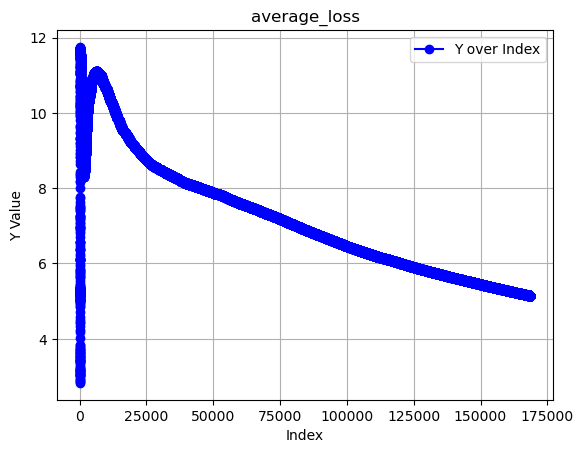

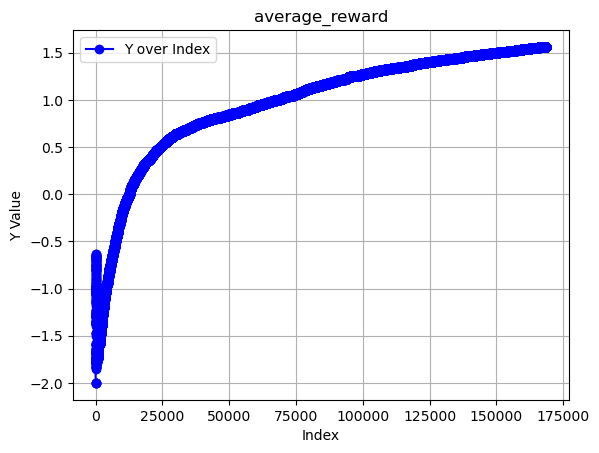

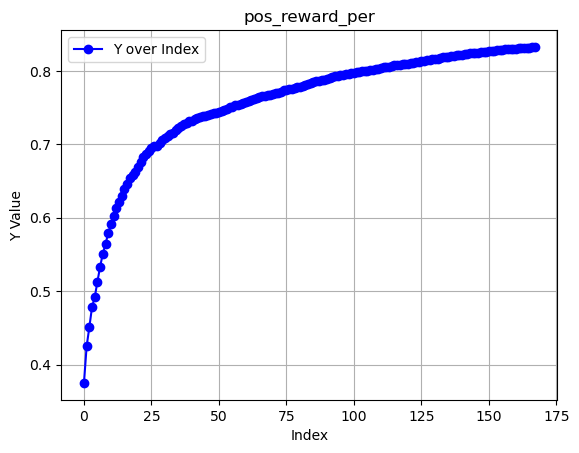

<IPython.core.display.Javascript object>

[2, 3]
[3]
[3]
[3]


In [30]:
def picture(a,key):
    x_values = list(range(len(a)))

        
    plt.plot(x_values, a, marker='o', linestyle='-', color='blue', label='Y over Index')

    plt.title(key)
    plt.xlabel("Index")
    plt.ylabel("Y Value")

    plt.legend()
    plt.grid(True)

    plt.show()



# Reset scene: assign new A/B and reinitialize agents with paths
def reset_scene():
    global A, B, agents, step_counter
    
    test_dql_agent = DQL(statespace_size, lr, gamma, replay_buffer_size, batch_size, target_update_freq, epsilon, epsilon_decay, min_epsilon)
    test_dql_agent.main_nn = model
    test_dql_agent.main_nn.eval()
    test_dql_agent.epsilon = 0.0
    test_grid = grid_state(size, num_agents)
    test_grid.reset_grid()
    A = test_grid.A_location
    B = test_grid.B_location
    for i in range(4):
        if i == 0:
            test_grid.agent_list[i].x = B[0]
            test_grid.agent_list[i].y = B[1]
            test_grid.agent_list[i].has_item = False
        else:
            test_grid.agent_list[i].x = A[0]
            test_grid.agent_list[i].y = A[1]
            test_grid.agent_list[i].has_item = True
            
        
    step_counter[0] = 0
    
    
    
    deliver(test_grid,test_dql_agent,25)
    agents = []
    for i in range(4):
        print(test_grid.agent_list[i].path)
        if i == 0:
            agents.append({"x": B[0], "y": B[1], "path": test_grid.agent_list[i].path, "step": 0})
        else:
            agents.append({"x": A[0], "y": A[1], "path": test_grid.agent_list[i].path, "step": 0})
# Move agent based on its predefined path
def move_agent(agent):
    if agent["step"] < len(agent["path"]):
        direction = agent["path"][agent["step"]]
        dx, dy = direction_map[direction]
        agent["x"] = max(0, min(grid_size - 1, agent["x"] + dx))
        agent["y"] = max(0, min(grid_size - 1, agent["y"] + dy))
        agent["step"] += 1

# Update each frame
def update(frame):
    ax.clear()
    ax.set_xlim(-0.5, grid_size - 0.5)
    ax.set_ylim(-0.5, grid_size - 0.5)
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.grid(True)

    # Draw A and B as stars
    ax.plot(A[0], A[1], marker='*', color='red', markersize=15, label='A')
    ax.plot(B[0], B[1], marker='*', color='blue', markersize=15, label='B')

    # Draw agents
    for i, agent in enumerate(agents):
        ax.plot(agent['x'], agent['y'], 'o', color=colors[i], markersize=12, label=f'Agent {i+1}')

    ax.legend(loc='upper left')

    # Move one agent per frame (in round-robin order)
    if agents:
        idx = step_counter[0] % len(agents)
        move_agent(agents[idx])
        step_counter[0] += 1


    
if __name__ == "__main__":
    # hyper-parameter for DQL agent
    statespace_size = 19
    lr = 1e-3
    gamma = 0.95   # discount factor for future reward
    replay_buffer_size = 50000
    batch_size = 64
    target_update_freq = 50
    epsilon = 1.0    # decay after each episode
    epsilon_decay = 0.99951
    min_epsilon = 0.05
    
    # hyper-parameter for grid agent
    size = 5
    num_agents = 4
    
    # hyper-parameter for training process
    num_episodes = 41000
    max_steps = 36
    
    dql_agent = DQL(statespace_size, lr, gamma, replay_buffer_size, batch_size, target_update_freq, epsilon, epsilon_decay, min_epsilon)
    grid_agent = grid_state(size, num_agents)
    
    train_process(dql_agent,grid_agent,num_episodes,max_steps)
    print("=========")
    print(grid_agent.total_cost,grid_agent.total_collisions)
    model = dql_agent.main_nn
    test(statespace_size, lr, gamma, replay_buffer_size, batch_size, target_update_freq, epsilon, epsilon_decay, min_epsilon,model,20,size, num_agents)
    test(statespace_size, lr, gamma, replay_buffer_size, batch_size, target_update_freq, epsilon, epsilon_decay, min_epsilon,model,25,size, num_agents )
    key1 = "average_loss"
    key2 = "average_reward"
    key3 = "pos_reward_per"
    %matplotlib inline
    picture(avg_loss,key1)
    picture(avg_reward,key2)
    picture(pos_reward_per,key3)
    %matplotlib notebook
    # Grid size
    grid_size = 5

    # Global variables
    agents = []
    A = B = (0, 0)
    step_counter = [0]
    colors = ['green', 'orange', 'purple', 'black']

    # Movement direction mapping: 0=up, 1=down, 2=left, 3=right
    direction_map = {
        0: (0, 1),
        1: (0, -1),
        2: (-1, 0),
        3: (1, 0)
    }

    fig, ax = plt.subplots(figsize=(5, 5))
    plt.subplots_adjust(bottom=0.2)

    

    # Initialize
    reset_scene()

    # Animate
    ani = animation.FuncAnimation(fig, update, frames=100, interval=500, cache_frame_data=False)
    display(HTML(ani.to_jshtml()))
    #plt.show()

### Use of Generative AI
- For the hyperparameters in the training, I used chatgpt to provide the suggested initial values for my questions and adjusted the hyperparameters after multiple tests

- For the visualization part of the project, I asked chatgpt to provide the code framework

### resource
- https://chatgpt.com